# Linear Regression

Linear regression models are a good starting point for regression tasks.
Such models are popular because they can be fit very quickly, and are very interpretable.
You are probably familiar with the simplest form of a linear regression model (i.e., fitting a straight line to data) but such models can be extended to model more complicated data behavior.

In this section we will start with a quick intuitive walk-through of the mathematics behind this well-known problem, before seeing how before moving on to see how linear models can be generalized to account for more complicated patterns in data.

We begin with the standard imports:

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from scipy import stats

## Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data.
A straight-line fit is a model of the form
$$
y = ax + b
$$
where $a$ is commonly known as the *slope*, and $b$ is commonly known as the *intercept*.

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5:

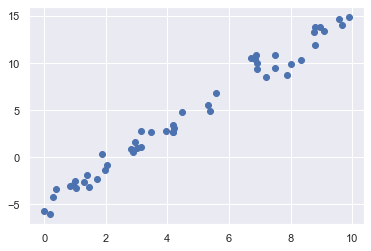

In [4]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

We can use Scikit-Learn's ``LinearRegression`` estimator to fit this data and construct the best-fit line:

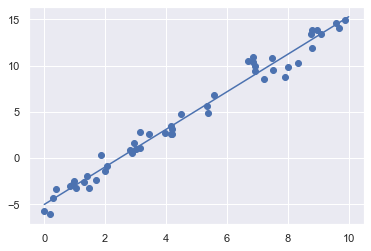

In [5]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore.
Here the relevant parameters are ``coef_`` and ``intercept_``:

In [10]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.0272088103606944
Model intercept: -4.9985770855532


The ``LinearRegression`` estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle multidimensional linear models of the form
$$
y = a_0 + a_1 x_1 + a_2 x_2 + \cdots
$$
where there are multiple $x$ values.
Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.



# Support Vector Machines

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
In this section, we will develop the intuition behind support vector machines and their use in classification problems.

SVM consider instead *discriminative classification*: rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated:

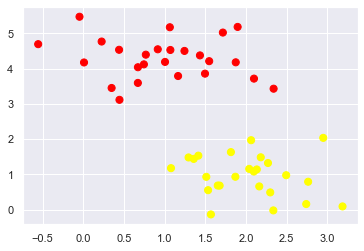

In [14]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

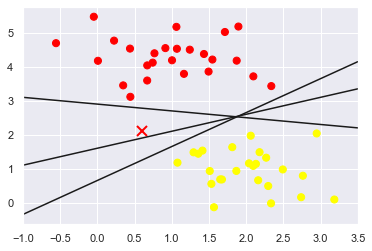

In [16]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Support Vector Machines: Maximizing the *Margin*

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look:

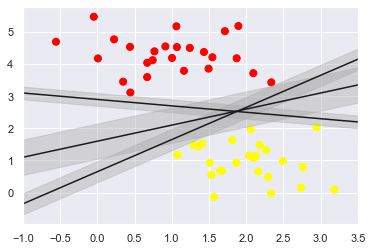

In [17]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [19]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [21]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

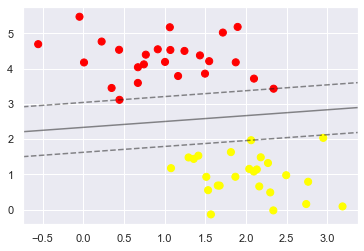

In [22]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure.
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

In [25]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

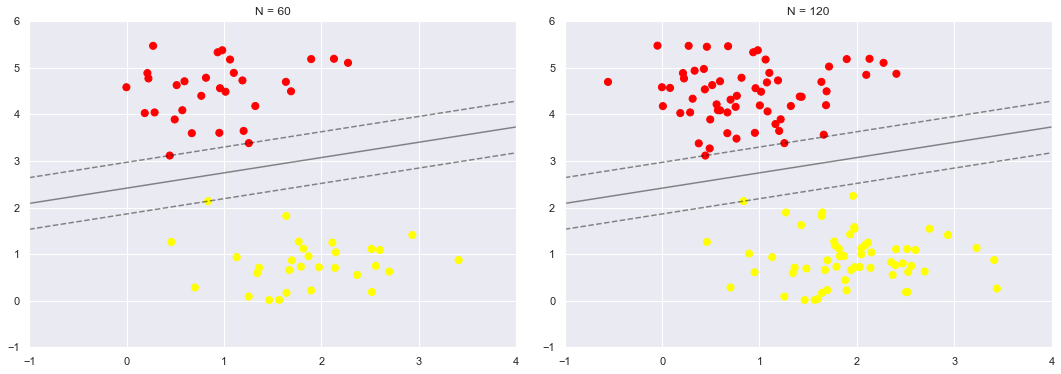

In [26]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

In [ ]:
### Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with *kernels*.
are able to fit for nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea.
To motivate the need for kernels, let's look at some data that is not linearly separable:

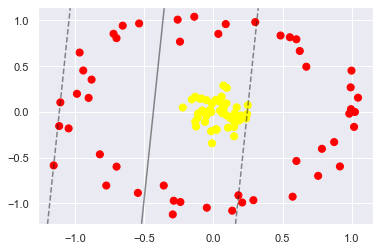

In [28]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will *ever* be able to separate this data.
But we can think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.
For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [30]:
r = np.exp(-(X ** 2).sum(1))

In [35]:
from ipywidgets import interact, fixed

In [37]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.
In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

In [38]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

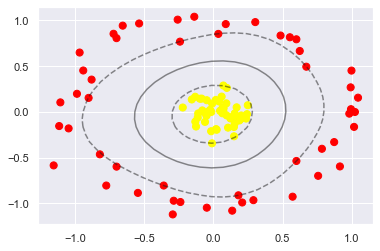

In [39]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

## Example: Diabetes Prediction
The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset
https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

In [40]:
import pandas as pd


In [41]:
data = pd.read_csv('../Data/Diabetes/diabetes.csv')
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [42]:
data.shape

(768, 9)

In [43]:
#data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [44]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [51]:
data["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

<AxesSubplot:xlabel='Outcome'>

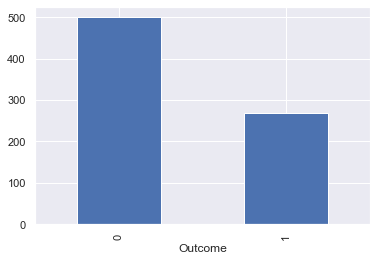

In [45]:
data.groupby('Outcome').size().plot(kind='bar')

In [46]:
data.corr(method='pearson')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [48]:
#sns.pairplot(data)

In [50]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler #(standardize data to common range)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [53]:
X= data.drop(columns="Outcome",axis=1)
y=data["Outcome"]

### Train Test Split

In [54]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y, random_state=2)

### Model Training

In [55]:
classifier=svm.SVC(kernel='linear')

In [56]:
classifier.fit(X_train,y_train)

SVC(kernel='linear')

### Evaluating Model

In [57]:
# accuracy_score of training data

X_train_prediction=classifier.predict(X_train)
training_data_accuracy_score=accuracy_score(y_train,X_train_prediction)
print(f"Accuracy Score of training data : {training_data_accuracy_score * 100} %")

Accuracy Score of training data : 78.33876221498372 %


In [58]:
# accuracy_score of testing data

X_test_prediction=classifier.predict(X_test)
testing_data_accuracy_score=accuracy_score(y_test,X_test_prediction)
print(f"Accuracy Score of testing data : {testing_data_accuracy_score * 100} %")

Accuracy Score of testing data : 77.27272727272727 %


## Logistic Regression

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

array = data.values
X = array[:,0:8]
Y = array[:,8]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size,random_state=seed)
model = LogisticRegression()
model.fit(X_train, Y_train)
result = model.score(X_test, Y_test)
print("Accuracy: ",  (result*100.0))

Accuracy:  78.74015748031496


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
